# 9.1 残響除去問題の定義

* 残響の影響により、マイクで収録した音声は響きがあり聞き取りにくい音となる
* 残響除去技術：不要な残響音を除去して残響のない音声を作り出す技術$$x_{lk} = \Sigma_{i=1}^N \Sigma_{\tau=0}^{L_\tau-1} g_{i,\tau k} s_{i,l-\tau,k}$$
    * $g_{i,\tau k}$：時間周波数領域でのパルス応答
    * $L_\tau$：インパルス応答長
* マイクロホン入力信号 $x_{lk}$ から残響のない信号 $s_{ilk} を推定する問題

# 9.2 空間的な逆フィルタ

* multipleinput/output inverse theorem (MINT)：残響除去を行う上で重要な基礎理論、これにより複数マイクを用いた有限長のフィルタ（FIR フィルタ）で残響を完全に除去できることを示せる
* 複数のマイクロホン信号があればうまく直接音成分だけを復元できる可能性が出てくる
* 音源からマイクロホンまでのインパルス応答が既知であることを前提としたが、実際はインパルス応答を事前に知ることは、ステアリングベクトルが既知であることなど、BF における前提よりもはるかに難しい
* そこで過去の研究では、インパルス応答を何らかの方法で推定し、推定したインパルス応答に基づき逆フィルタを作成する方法が検討されている
* インパルス応答を正確に推定することが難しく、逆フィルタはインパルス応答の推定誤差に対して脆弱であることが知られている
* WPE(Weighted Prediction Error)：インパルス応答を推定することなく残響を除去できる手法として近年提案された、入力信号の線形予測に基づく残響除去法
  * 実装がとても簡単でありながら高い残響除去性能を有するため、実用的

# 9.3 線形予測に基づく残響除去

* 以下は最小二乗法による残響除去のコード

In [1]:
import wave
import pyroomacoustics as pa
import numpy as np
import scipy.signal as sp
import scipy as scipy
import matplotlib.pyplot as plt

In [7]:
def plot_spectrogram(data, sample_rate):
    """データからスペクトログラムを作成し、それをプロットする関数

    Parameters:
    data: numpy array
        音声データ
    sample_rate: int
        サンプリングレート（Hz）
    """
    fig = plt.figure(figsize=(10, 4))
    spectrum, freqs, t, im = plt.specgram(data, NFFT=512, noverlap=int(512 / 16 * 15), Fs=sample_rate, cmap="inferno")
    fig.colorbar(im).set_label("Intensity [dB]")
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()


def write_file_from_time_signal(signal, file_name, sample_rate, display=False):
    signal = signal.astype(np.int16)
    if display == True:
        plot_spectrogram(signal, sample_rate)
    with wave.open(file_name, "w") as wave_out:
        wave_out.setnchannels(1)
        wave_out.setsampwidth(2)
        wave_out.setframerate(sample_rate)
        wave_out.writeframes(signal)

In [8]:
# x:入力信号( M, Nk, Lt)
# D:遅延フレーム数
# Lh:残響除去フィルタのタップ長
# return x_bar: 過去のマイク入力信号(Lh,M,Nk,Lt)
def make_x_bar(x, D, Lh):
    # フレーム数を取得
    Lt = np.shape(x)[2]

    # 過去のマイク入力信号の配列を準備
    x_bar = np.zeros(shape=(Lh,) + np.shape(x), dtype=complex)

    for tau in range(Lh):
        x_bar[tau, ..., tau + D :] = x[:, :, : -(tau + D)]

    return x_bar


# 最小二乗で除去
# x:入力信号( M, Nk, Lt)
# x_bar:過去のマイク入力信号(Lh,M, Nk, Lt)
# return x_dereverb:残響除去後の信号(Nk,Lt)
def dereverberation_ls(x, x_bar):
    # マイクロホン数・周波数・フレーム数・タップ長を取得する
    M = np.shape(x)[0]
    Nk = np.shape(x)[1]
    Lt = np.shape(x)[2]
    Lh = np.shape(x_bar)[0]

    x_bar = np.reshape(x_bar, [Lh * M, Nk, Lt])
    x_bar_x_bar_h = np.einsum("ikt,jkt->kij", x_bar, np.conjugate(x_bar))
    # covariance_inverse=np.linalg.pinv(x_bar_x_bar_h)

    correlation = np.einsum("ikt,kt->ki", x_bar, np.conjugate(x[0, ...]))

    filter = np.linalg.solve(x_bar_x_bar_h, correlation)

    # filter=np.einsum('kij,kj->ki',covariance_inverse,correlation)
    x_reverb = np.einsum("kj,jkt->kt", np.conjugate(filter), x_bar)

    x_dereverb = x[0, ...] - x_reverb

    return x_dereverb


# SNRをはかる
# desired: 目的音、Lt
# out: 雑音除去後の信号 Lt
def calculate_snr(desired, out):
    wave_length = np.minimum(np.shape(desired)[0], np.shape(out)[0])
    # 消し残った雑音
    desired = desired[:wave_length]
    out = out[:wave_length]
    noise = desired - out
    snr = 10.0 * np.log10(np.sum(np.square(desired)) / np.sum(np.square(noise)))
    return snr


np.random.seed(0)

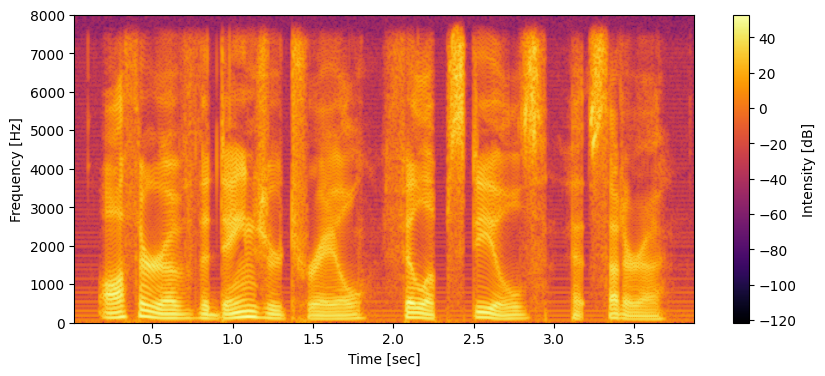

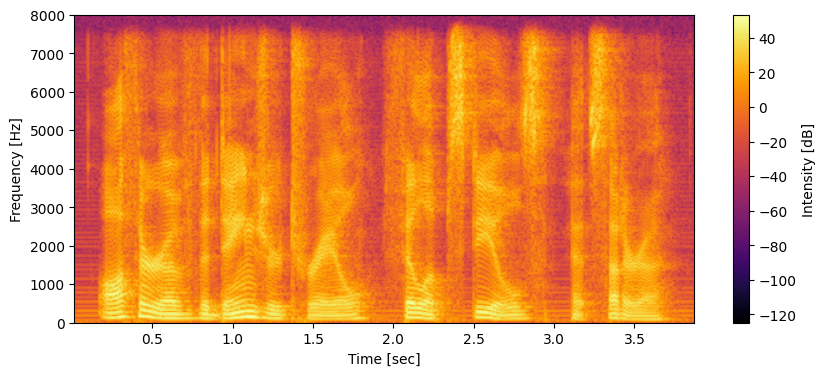

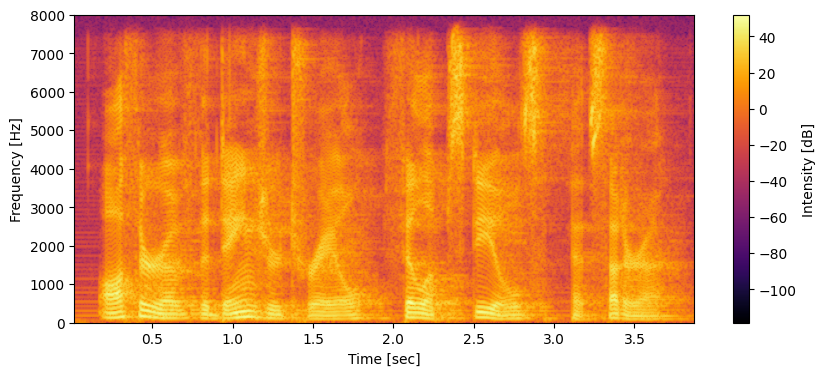

method:     LS
Δsnr [dB]: -4.76


In [10]:
clean_wave_files = ["../arctic_a0001.wav"]
n_sources = len(clean_wave_files)

# 長さを調べる
n_samples = 0
# ファイルを読み込む
for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    if n_samples < wav.getnframes():
        n_samples = wav.getnframes()
    wav.close()

clean_data = np.zeros([n_sources, n_samples])

# ファイルを読み込む
s = 0
for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max
    clean_data[s, : wav.getnframes()] = data
    wav.close()
    s = s + 1

# シミュレーションのパラメータ
# シミュレーションで用いる音源数
n_sim_sources = 1
# サンプリング周波数
sample_rate = 16000
# フレームサイズ
N = 1024
# フレームシフト
Nshift = int(N / 4)
# 周波数の数
Nk = int(N / 2 + 1)

# 各ビンの周波数
freqs = np.arange(0, Nk, 1) * sample_rate / N

# 音声と雑音との比率 [dB]
SNR = 90.0

# 部屋の大きさ
room_dim = np.r_[10.0, 10.0, 10.0]

# マイクロホンアレイを置く部屋の場所
mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1

# マイクロホンアレイのマイク配置
mic_directions = np.array([[np.pi / 2.0, theta / 180.0 * np.pi] for theta in np.arange(180, 361, 180)])

distance = 0.01
mic_alignments = np.zeros((3, mic_directions.shape[0]), dtype=mic_directions.dtype)
mic_alignments[0, :] = np.cos(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[1, :] = np.sin(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[2, :] = np.cos(mic_directions[:, 0])
mic_alignments *= distance

# マイクロホン数
n_channels = np.shape(mic_alignments)[1]

# マイクロホンアレイの座標
R = mic_alignments + mic_array_loc[:, None]

is_use_reverb = True
room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
room_no_reverb = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

# 用いるマイクロホンアレイの情報を設定する
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_reverb.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

# 音源の場所
doas = np.array([[np.pi / 2.0, np.pi]])

# 音源とマイクロホンの距離
distance = 1.0

source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

# 各音源をシミュレーションに追加する
for s in range(n_sim_sources):
    clean_data[s] /= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])
    room_no_reverb.add_source(source_locations[:, s], signal=clean_data[s])

# シミュレーションを回す
room.simulate(snr=SNR)
room_no_reverb.simulate(snr=90)

# 畳み込んだ波形を取得する(チャンネル、サンプル）
multi_conv_data = room.mic_array.signals
multi_conv_data_no_reverb = room_no_reverb.mic_array.signals

wave_len = np.shape(multi_conv_data_no_reverb)[1]

# 畳み込んだ波形をファイルに書き込む
write_file_from_time_signal(multi_conv_data_no_reverb[0, :wave_len] * np.iinfo(np.int16).max / 20.0, "./dereverb_clean.wav", sample_rate, display=True)

# 畳み込んだ波形をファイルに書き込む
write_file_from_time_signal(multi_conv_data[0, :wave_len] * np.iinfo(np.int16).max / 20.0, "./dereverb_in.wav", sample_rate, display=True)

# 短時間フーリエ変換を行う
f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N, noverlap=N - Nshift)

# WPEの繰り返し回数
n_wpe_iterations = 20

# 残響除去のパラメータ
D = 2
Lh = 5

# 過去のマイクロホン入力信号
x_bar = make_x_bar(stft_data, D, Lh)

# LSで残響除去
x_dereverb_ls = dereverberation_ls(stft_data, x_bar)

# x:入力信号( M, Nk, Lt)
t, x_dereverb_ls = sp.istft(x_dereverb_ls, fs=sample_rate, window="hann", nperseg=N, noverlap=N - Nshift)

snr_pre = calculate_snr(multi_conv_data_no_reverb[0, ...], multi_conv_data[0, ...])
snr_ls_post = calculate_snr(multi_conv_data_no_reverb[0, ...], x_dereverb_ls)

write_file_from_time_signal(x_dereverb_ls[:wave_len] * np.iinfo(np.int16).max / 20.0, f"./dereverb_ls_{Lh}_{D}.wav", sample_rate, display=True)

print("method:    ", "LS")
print("Δsnr [dB]: {:.2f}".format(snr_ls_post - snr_pre))

* 結果が芳しくない
* 最小二乗法による残響除去後の出力信号は、無残響信号とは程遠く、残響信号と比較してかえって残響が増えている
* 2 つの要因が考えられる
  * 直接音成分と残響成分が無相関であるという過程が厳密には誤り
  * コスト関数を残響除去後の信号の音量の期待値としたが、残響除去後の信号には直接音成分が含まれているため、直接音成分が大きい時間ほど積極的に直接音を除去するように最適化される危険性がある

# 9.4 時変ガウスモデルを用いた残響除去

* マルチステップ線形予測法：直接音と初期反射音が相関を持つことの解決法
  * 初期反射音は直接音と高い相関をもつので、除去しなくても実用上問題がない
* コスト関数の問題に対して、時間ごとに重み付きのコスト関数を用いる方法で対処
* Weighted Prediction Error(WPE) では残響除去フィルタと時間周波数ごとに変化する音声の分散を、コスト関数が単調減少するように最適化
* 以下は WPE による残響除去のコード

In [11]:
# WPEで残響を除去
# x:入力信号( M, Nk, Lt)
# x_bar:過去のマイク入力信号(Lh,M, Nk, Lt)
# return x_dereverb:残響除去後の信号(Nk,Lt)
def dereverberation_wpe(x, x_bar, wpe_iterations=10):
    # マイクロホン数・周波数・フレーム数・タップ長を取得する
    M = np.shape(x)[0]
    Nk = np.shape(x)[1]
    Lt = np.shape(x)[2]
    Lh = np.shape(x_bar)[0]

    # 入力信号の形式を変更・変数を初期化
    x_bar = np.reshape(x_bar, [Lh * M, Nk, Lt])
    v = np.square(np.abs(x[0, ...]))

    cost_buff = []
    for t in range(wpe_iterations):
        # 共分散行列を計算
        x_bar_x_bar_h = np.einsum("kt,ikt,jkt->kij", 1.0 / v, x_bar, np.conjugate(x_bar))

        # 相関ベクトルを計算
        correlation = np.einsum("kt,ikt,kt->ki", 1.0 / v, x_bar, np.conjugate(x[0, ...]))

        # フィルタ算出
        filter = np.linalg.solve(x_bar_x_bar_h, correlation)

        # 残響除去実施
        x_reverb = np.einsum("kj,jkt->kt", np.conjugate(filter), x_bar)
        x_dereverb = x[0, ...] - x_reverb

        # パラメータ更新
        v = np.square(np.abs(x_dereverb))
        v = np.maximum(v, 1.0e-8)

        # コスト計算
        cost = np.mean(np.log(v))
        cost_buff.append(cost)
    return (x_dereverb, cost_buff)

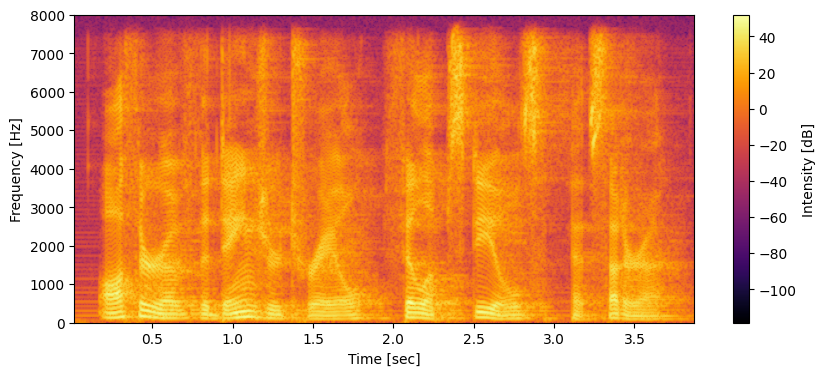

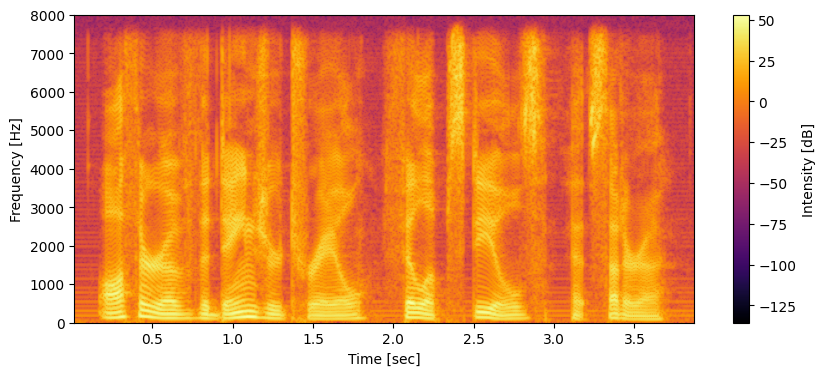

method:     LS WPE
Δsnr [dB]: -4.76  7.79


In [12]:
# 短時間フーリエ変換を行う
f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N, noverlap=N - Nshift)

# WPEの繰り返し回数
n_wpe_iterations = 20

# 残響除去のパラメータ
D = 2
Lh = 5

# 過去のマイクロホン入力信号
x_bar = make_x_bar(stft_data, D, Lh)

# LSで残響除去
x_dereverb_ls = dereverberation_ls(stft_data, x_bar)

# WPEで残響除去
x_dereverb_wpe, cost_buff_wpe = dereverberation_wpe(stft_data, x_bar, n_wpe_iterations)

# x:入力信号( M, Nk, Lt)

t, x_dereverb_ls = sp.istft(x_dereverb_ls, fs=sample_rate, window="hann", nperseg=N, noverlap=N - Nshift)
t, x_dereverb_wpe = sp.istft(x_dereverb_wpe, fs=sample_rate, window="hann", nperseg=N, noverlap=N - Nshift)

snr_pre = calculate_snr(multi_conv_data_no_reverb[0, ...], multi_conv_data[0, ...])
snr_ls_post = calculate_snr(multi_conv_data_no_reverb[0, ...], x_dereverb_ls)
snr_wpe_post = calculate_snr(multi_conv_data_no_reverb[0, ...], x_dereverb_wpe)

write_file_from_time_signal(x_dereverb_ls[:wave_len] * np.iinfo(np.int16).max / 20.0, "./dereverb_ls_{}_{}.wav".format(Lh, D), sample_rate, display=True)
write_file_from_time_signal(x_dereverb_wpe[:wave_len] * np.iinfo(np.int16).max / 20.0, "./dereverb_wpe_{}_{}.wav".format(Lh, D), sample_rate, display=True)


print("method:    ", "LS", "WPE")
print(f"Δsnr [dB]: {(snr_ls_post - snr_pre):.2f}  {(snr_wpe_post - snr_pre):.2f}")

# コストの値を表示
# for t in range(n_wpe_iterations):
#    print(t,cost_buff_wpe[t])

* WPE による出力結果が最小二乗法による残響除去の出力信号よりも、無残響信号に近づいている
* D を 1 に設定した場合は初期反射音を抑圧するようにフィルタが最適化されるが、初期反射音と相関が高い直接音も同時に除去されることから、SNR 改善率は負の値になる
* D を 2 に設定した場合は SNR が大幅に改善される
* WPE は音声認識の前処理として広く使われるメジャーな技術
  * 聞きたい直接音を歪ませることが少なく、音声認識の前処理として適している
  * 繰り返し計算の回数も音源分離と比較して少ない回数で良い性能が出るため、計算量が少ないことも利点
  * WPE よりも高性能の残響除去技術が提案されているが、WPE が使われ続けるのは、計算量の少なさと実装の簡易さ